# Text Generation with Recurrent Neural Nets
<b>Authors:</b>   
Kyle Hays  
Kellen Rice

## Introduction
We will be using Python's TensorFlow library to train a recurrent neural network to predict text using the full text of Lewis Carroll's "Alice in Wonderland"
source: https://raw.githubusercontent.com/grbruns/cst383/master/alice.txt
Inspiration and basic processes for this assignment will be gathered from examination of code from: https://gist.github.com/karpathy/d4dee566867f8291f086. Written by Andrej Karpathy in "pure" python (i.e. not using any TensorFlow.

Our goal is to train the system well enough to where we can synthesize our own output to contain words and sentences that are not only readable in the sense of containing mostly real words, but also to follow a similar style of the input text. If we have enough time and our model proves successful, we will try to train on some other dataset (some other book or set of text) and try to generate text in that style as well. For this second experiment we are leaning toward David Foster Wallace's "Infinite Jest". 

### Imports

In [ ]:
import seaborn as sns

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import itertools
from itertools import product
import re
import pandas as pd
import time
import requests

### Read in text of "Alice in Wonderland"

In [5]:
#r = requests.get('https://raw.githubusercontent.com/grbruns/cst383/master/alice.txt')
#data_raw = r.content
r = open('input.txt', 'r')
data_raw = r.read()

### Basic Preprocessing
We need to take the raw data and turn it into more easily parsed text. 
We will also make a note of the count of occurances of various character in the text, as well as the count of unique characters in the text. 

In [10]:
data = str(data_raw)
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))

#helper function to convert char to index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 144393 characters, 69 unique.


### Basic mapping of characters to numeric values, and vice-versa for later when we are performing our training and predictions
Creating a dictionary looking converter between characters and integer values will help us very quickly convert to/from an encoded array and character values for training and generating our "synthetic" text output. 

In [11]:
print(char_to_ix,'\n','\n', ix_to_char)

{'*': 0, 'N': 1, 'L': 36, 'J': 2, 'H': 3, ';': 5, 'i': 6, '[': 7, 'n': 8, 's': 9, ':': 10, 'P': 11, 'S': 12, 'a': 13, 'F': 17, 'c': 15, 'X': 20, 'V': 18, 'j': 19, 'Y': 21, 'B': 22, 'O': 23, 't': 4, 'D': 25, '.': 26, 'e': 30, ']': 31, 'W': 32, ',': 34, 'A': 35, 'x': 37, 'z': 39, 'l': 64, 'y': 48, 'U': 24, 'v': 41, 'M': 38, '\n': 42, 'Z': 29, 'r': 43, '_': 45, 'm': 46, 'R': 47, 'K': 28, 'G': 49, ' ': 50, 'b': 58, "'": 51, 'f': 52, 'E': 53, 'p': 65, 'T': 54, '!': 56, 'C': 55, 'w': 57, 'Q': 40, '(': 59, '"': 60, '-': 44, 'q': 33, 'k': 67, 'I': 61, ')': 62, 'd': 63, 'h': 14, '?': 27, 'o': 66, 'u': 16, 'g': 68} 
 
 {0: '*', 1: 'N', 2: 'J', 3: 'H', 4: 't', 5: ';', 6: 'i', 7: '[', 8: 'n', 9: 's', 10: ':', 11: 'P', 12: 'S', 13: 'a', 14: 'h', 15: 'c', 16: 'u', 17: 'F', 18: 'V', 19: 'j', 20: 'X', 21: 'Y', 22: 'B', 23: 'O', 24: 'U', 25: 'D', 26: '.', 27: '?', 28: 'K', 29: 'Z', 30: 'e', 31: ']', 32: 'W', 33: 'q', 34: ',', 35: 'A', 36: 'L', 37: 'x', 38: 'M', 39: 'z', 40: 'Q', 41: 'v', 42: '\n', 43: 

### A look at our cleaned text, ready for analysis

In [6]:
print(data)


ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversations?'

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so
VERY much out of the way to hear the Rabbit say to itself, 'Oh dear!
Oh dear! I shall be late!' (when she thought it over afterwards, it
occurred to her that she ought to have wondered at this, but at the time
it all seemed quite natural); but when t

In [7]:
import operator
char_counts = {}
for char in data:
    if char in char_counts:
        char_counts[char] += 1
    else:
        char_counts[char] = 1
        
sorted_chars_count = sorted(char_counts.items(), key=operator.itemgetter(1), reverse = True)

chars = [char for char,_ in sorted_chars_count]
counts = [count for _,count in sorted_chars_count]

### Vizualise character occurances

<Figure size 800x800 with 0 Axes>

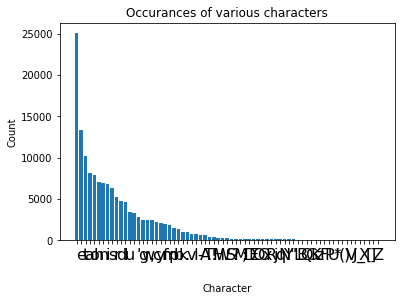

<Figure size 800x800 with 0 Axes>

In [8]:
from matplotlib.pyplot import figure
plt.bar(chars, counts)
plt.xticks(fontsize = 16)
plt.title("Occurances of various characters")
plt.xlabel("Character")
plt.ylabel("Count")
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')



Spaces dominate all other characters. Then most vowels appear to be the most frequent. After that we see the rest of the lower-case letters, and then on the less frequent end we see special characters, and upper-case letters.

# The Building Process
The process of building the resultant model was a long and arduous task of trial and error. We began by examining the Karpathy code to see what kind of information was being fed into his model. We found from our examination that he was feeding a sequence of 25 characters each one-hot-encoded to an array of 69; equal to the vocabulary size of the text. We used this input shape to start building our tensorflow net. We initially set up our input layer X and y to take in a batch of size X:(batch_size, n_steps, vocab_size), y:(batch_size, n_steps, vocab_size). We then fed this into a BasicRNNCell to retrieve the outputs, states from the RNN net.

We realized at this point that the outputs was not in the correct shape for analysis with cross entropy. We passed our outputs through a dense layer with the neurons = vocab_size to achieve an output tensor of shape (batch_size, n_steps, vocab_size). At this point we tried to feed our logits into a sparse_softmax_cross_entropy_with_logits layer and ran into a dimension error. The y batch must always be 1 dimension less to allow examination with sparse_softmax_cross_entropy_with_logits which takes in a y batch one dimension less than the logit tensor’s shape. To solve this we modified the y tensor to intake a y:(batch_size, n_steps) removing the one hot encoding of the label.  

At this point we began training our net using an AdamOptimizer to reduce_mean. Once our net was training properly minimizing loss we focused our attention on sampling the model. This is the point where we ran into the most trial and error issues. We began by examining the Karpathy code to see how he samples from his model. We noticed that we was passing in a single character and predicting what character followed to produce output. We setup our net to take in a shape value of None for most of the shape variables in our input layer. This allowed us to use any shape X_batch and y_batch for sampling. We first retrieved the probabilities of our logits by passing them through a softmax layer. Intuitively we thought to sample the item that is predicted the most in our sample method. We later found this to be improper and instead we switched to using the probabilities to pick from a distribution. 

When building our sample function we began by feeding in a single character and predicting the next letter based off of that starting character. We would then feed in the predicted character to the model to get the next predicted character and so on. After running a couple of models we realized that our output was not correct given we would achieve a loss of 1.55 and an accuracy of .68 with an output that was meaningless. 

We addressed this issue by feeding in the sample method a progressively bigger series. As the model predicted the next letter we would append this to a running sequence of predicted letters to feed back into the model. By feeding the model a progressively larger sequence of its predicted characters we were able to achieve similar output to karpathy's model in a similar amount of time. At this point we knew we were done building the base model and sampling methods and moved onto more advanced models. 

## Model Selector Class
To help streamline our process and to make the code more reusable and capable of a grid search we will later perform, we will encapsulate the building of the TensorFlow graph into a class that will also handle text sampling, one-hot encoding, batching, and generation of our "novel" text. 

# The examination section includes

###### accuracy: training batch accuracy

###### loss: training batch loss

###### expected output: the expected output from the batch

######   actual output: the actual output the model predicted

###### output: the output generated from our sample method

In [35]:
class model_selector():
    '''
    model_selection using api calls
    '''
    def args(self, layer_type, n_layers, 
             vocab_size, learning_rate, 
             n_steps, n_batches, n_epochs, 
             verbose, len_sentence, n_neurons, 
             grid_run, specified_outputs):
        '''
        Graph building arguments
        '''
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.n_inputs = vocab_size
        self.n_outputs = vocab_size 
        self.vocab_size = vocab_size
        self.learning_rate = learning_rate
        
        
        '''
        Training Arguments
        '''
        self.n_steps = n_steps
        self.n_batches = n_batches
        self.batch_size = n_steps
        self.n_epochs = n_epochs
        self.len_sentence = len_sentence
        self.verbosity = verbose 
        self.specified_outputs= specified_outputs
        
        '''
        Coonfigure local dependencies
        '''
        self.root_logdir = '/home/snoelover18/tf_logs/'
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        
        self.grid_run = grid_run
        
        '''
        Setup One hot encoder for vocab_size
        '''
        self.my_encoder = {}
        for t in range(vocab_size):
            self.my_encoder[t] = np.zeros((vocab_size, 1))
            self.my_encoder[t][t] = 1    
            
    def initialize(self, parameters, grid_run, specified_outputs):
        '''
        Initialize the model:
            Sets the parameters of the model.
            Builds the graph.
            Begins the training loop.
        '''
        self.parameters=parameters
        self.args(layer_type=parameters['layer_type'], 
                  n_layers=parameters['n_layers'], 
                  vocab_size=parameters['vocab_size'], 
                  learning_rate=parameters['learning_rate'], 
                  n_steps=parameters['n_steps'], 
                  n_batches=parameters['n_batches'],
                  n_epochs=parameters['n_epochs'], 
                  verbose=parameters['verbose'],
                  len_sentence=parameters['len_sentence'], 
                  n_neurons=parameters['n_neurons'],
                  grid_run = grid_run, specified_outputs = specified_outputs)

        print('---------------------------------------------------------------------------')
        print('MODEL INITIALIZING')
        X_batch, y_batch = self.fetch_batch(self.n_batches, self.batch_size)
        print('Batch Shape X:', X_batch.shape)
        print('Batch Shape y:', y_batch.shape)
        self.graph_build()
        print('MODEL INITIALIZED')
        print('---------------------------------------------------------------------------')
        self.train_model()
    
    def sample(self, len_sentence):
        '''
        Sample from the model:
            Samples from the model starting from a random index.
            Feeds the prediction.eval time step i and all previous steps.
            Single time step evaluation proved to not work.
        '''
        indicies=[]
        ix = np.random.randint(vocab_size)
        indicies.append(ix)
        test_batch = np.zeros((1, len_sentence, self.vocab_size))
        
        for i in range(len_sentence):
            test_batch[0, i, :][ix] = 1
            p = self.prediction.eval(feed_dict = {self.X:test_batch[:, :i+1, :]})
            p = p[0][i].ravel()
            ix = np.random.choice(range(self.vocab_size), p=p)
            indicies.append(ix)
        return indicies
    
    def sample_last_model(self, len_sentence, model_name, graph_name):
        '''
        Sample the last model of the given model
        '''
        saver = tf.train.Saver()
        #saver = tf.train.import_meta_graph(graph_name)
        
        with tf.Session() as sess:   
            #saver.restore(sess, tf.train.latest_checkpoint(model_name))
            #sess.run(tf.globarl_variables_initalizer())
            saver.restore(sess ,'my_model_final_machine_final_2.ckpt') 
            indicies=[]
            ix = np.random.randint(self.vocab_size)
            indicies.append(ix)
            test_batch = np.zeros((1, len_sentence, self.vocab_size))
            for i in range(len_sentence):
                test_batch[0, i, :][ix] = 1
                p = sess.run([self.prediction], feed_dict = {self.X:test_batch[:, :i+1, :]})
                p = p[0][0][i].ravel()
                ix = np.random.choice(range(self.vocab_size), p=p)
                indicies.append(ix)
            print('OUTPUT:',''.join([ix_to_char[ix] for ix in indicies]),'\n')
            print('---------------------------------------------------------------------------')

    def fetch_batch(self, n_batches, batch_size,):
        '''
        Method to retrieve a one hot encoded batch.
        '''
        X_batch = []
        y_batch = []
        for _ in range(n_batches):
            p = np.random.randint(len(data)-batch_size, size=1)[0] 
            X_batch.append([self.my_encoder[char_to_ix[ch]].ravel() for ch in data[p:p+batch_size]])
            y_batch.append([char_to_ix[ch] for ch in data[p+1:p+batch_size+1]])
        return np.array(X_batch), np.array(y_batch)

    def retrieve_args(self):
        '''
        Retrieve model arguments for grid search.
        '''
        return [self.grid_run, self.parameters,
                self.loss_train, self.accuracy_train, 
                self.loss_valid, self.accuracy_valid, 
                self.output_arg]
    

    def graph_build(self):
        '''
        Method to build the Tensorflow Graph.
        '''
        he_init = tf.keras.initializers.glorot_uniform(seed=None)
        tf.reset_default_graph()
        
        with tf.name_scope('inputs'):
            self.X = tf.placeholder(tf.float32, [None, None, self.n_inputs])
            self.y = tf.placeholder(tf.int64, [None, None])

        with tf.name_scope('cells'):
            if self.layer_type == 'LSTM':
                cells = [tf.nn.rnn_cell.LSTMCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            elif self.layer_type == 'GRU':
                cells = [tf.nn.rnn_cell.GRUCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            else:
                cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            multi_cell = tf.contrib.rnn.MultiRNNCell(cells)
            outputs, states = tf.nn.dynamic_rnn(multi_cell, self.X, dtype=tf.float32)
            
        with tf.name_scope('outputs'):
            logits = tf.layers.dense(outputs, self.vocab_size,
                                     name='dense', activation = tf.nn.leaky_relu, 
                                     kernel_initializer = he_init)

        with tf.name_scope('accuracy/evaluation'):
            self.output = tf.argmax(logits, axis=2, name='output')
            self.prediction = tf.nn.softmax(logits)
            self.correct_pred = tf.equal(self.output[self.n_batches-1], self.y[self.n_batches-1])
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        with tf.name_scope('training'):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.y, name='loss')
            self.loss = tf.reduce_mean(xentropy)
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
        print('Graph Shape')
        print('X:', self.X.shape)
        print('y:', self.y.shape)
        print('outputs:', outputs.shape)
        print('states:', states[-1][1].shape)
        print('logits:', logits.shape)
        print('prediction', self.prediction.shape)
        print('output:', self.output.shape)
        
    def train_model(self):
        '''
        Run Train model Session.
        Set up logging for tensorboard
        '''
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(self.root_logdir, now)
        loss_summary = tf.summary.scalar('loss', self.loss)
        accuracy_summary = tf.summary.scalar('accuracy_train', self.accuracy)
        loss_summary_valid = tf.summary.scalar('loss_valid', self.loss)
        accuracy_summary_valid = tf.summary.scalar('accuracy_train_valid', self.accuracy)
        file_write = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
        saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        
        timeout = time.time() + 60 * 106
        
        with tf.Session(config=self.config) as sess:
            init.run()
            self.output_arg = []
            for _ in range(self.n_epochs):
                X_batch, y_batch = self.fetch_batch(self.n_batches, self.batch_size)
                X_valid, y_valid = self.fetch_batch(self.n_batches, self.batch_size)
                sess.run(self.train_op, feed_dict = {self.X: X_batch, self.y:y_batch})
                
        
                if _%self.n_epochs == 0 and _ != 0:
                    self.accuracy_train = self.accuracy.eval(feed_dict = {self.X: X_batch, self.y:y_batch})
                    self.loss_train = self.loss.eval(feed_dict = {self.X: X_batch, self.y:y_batch})
                    self.accuracy_valid = self.accuracy.eval(feed_dict = {self.X: X_valid, self.y:y_valid})
                    self.loss_valid = self.loss.eval(feed_dict = {self.X: X_valid, self.y:y_valid})

                    indicies = self.sample(self.len_sentence)
                    string = ''.join([ix_to_char[ix] for ix in indicies])
                    self.output_arg.append(string)
                    file_path_2 = "./my_model_final_machine_final2_" + str(self.grid_run) + ".ckpt"
                    save_path = saver.save(sess, file_path_2)
                    for i in range(self.specified_outputs):
                        indicies = self.sample(self.len_sentence)
                        print()
                        print('OUTPUT:',''.join([ix_to_char[ix] for ix in indicies]),'\n')
                        
                if time.time() > timeout:
                    self.accuracy_train = self.accuracy.eval(feed_dict = {self.X: X_batch, self.y:y_batch})
                    self.loss_train = self.loss.eval(feed_dict = {self.X: X_batch, self.y:y_batch})
                    self.accuracy_valid = self.accuracy.eval(feed_dict = {self.X: X_valid, self.y:y_valid})
                    self.loss_valid = self.loss.eval(feed_dict = {self.X: X_valid, self.y:y_valid})

                    indicies = self.sample(self.len_sentence)
                    string = ''.join([ix_to_char[ix] for ix in indicies])
                    self.output_arg.append(string)
                    file_path_2 = "./my_model_final_machine_final2_" + str(self.grid_run) + ".ckpt"
                    save_path = saver.save(sess, file_path_2)
                    for i in range(self.specified_outputs):
                        indicies = self.sample(self.len_sentence)
                        print()
                        print('OUTPUT:',''.join([ix_to_char[ix] for ix in indicies]),'\n')
                    break;

                if _ %10 == 0:
                    self.summary_str = loss_summary.eval(feed_dict={self.X: X_batch, self.y: y_batch})
                    self.summary_str2 = accuracy_summary.eval(feed_dict={self.X: X_batch, self.y: y_batch})
                    self.summary_str3 = loss_summary_valid.eval(feed_dict={self.X: X_valid, self.y: y_valid})
                    self.summary_str4 = accuracy_summary_valid.eval(feed_dict={self.X: X_valid, self.y: y_valid})
                    step = _ *self.n_batches
                    file_write.add_summary(self.summary_str, step)   
                    file_write.add_summary(self.summary_str2, step)
                    file_write.add_summary(self.summary_str3, step)
                    file_write.add_summary(self.summary_str4, step)
                    
                    
                    
                    if _ %self.verbosity == 0:
                        print('epoch', _)
                        print('current time:', datetime.now().time())
                        print('accuracy', self.accuracy.eval(feed_dict = {self.X: X_batch, self.y:y_batch}))
                        print('loss', self.loss.eval(feed_dict = {self.X: X_batch, self.y:y_batch}))
                        print('y_batch examination:')
                        print('expected output:', ''.join([ix_to_char[ix] for ix in y_batch[self.n_batches-1].ravel()]))
                        print('  actual output:', ''.join([ix_to_char[ix] for ix in self.output.eval(
                            feed_dict = {self.X: X_batch, self.y:y_batch})[self.n_batches-1].ravel()]))
                        
                        indicies = self.sample(self.len_sentence)
                        print()
                        print('OUTPUT:',''.join([ix_to_char[ix] for ix in indicies]),'\n')
                        #PERFORM EARLY STOPPING HERE
                        file_path_2 = "./my_model_final_machine_final2_" + str(self.grid_run) + ".ckpt"
                        save_path = saver.save(sess, file_path_2)

                        print('---------------------------------------------------------------------------')

## Our Karpathy-esque Recurrent Nueral Net
Karpathy's code works well, but is very difficult to parse in terms of understanding what's going on. Many of the variable names aren't very helpful at all in terms of understanding what they represent. But the logic and math is all very well done. Here we've taken the basic structure of Karpathy's code and turned it into a TensorFlow implementation.

In [15]:
#KARPATHY MODEL
selector = model_selector()
parameters = {
                #TRAINING ARGS
                'vocab_size': vocab_size,
                'n_steps': 25,
                'n_batches': 1,
                'n_epochs': 5000,
    
                #GRAPH ARGS
                'layer_type':'RNN',
                'n_layers': 1,
                'n_neurons': 100,
                'learning_rate': 0.00505,
    
                #ANALYSIS ARGS
                'verbose':1000,
                'len_sentence':100      
            }

selector.initialize(parameters, 0, 0)

---------------------------------------------------------------------------
MODEL INITIALIZING
Batch Shape X: (1, 25, 69)
Batch Shape y: (1, 25)
Graph Shape
X: (?, ?, 69)
y: (?, ?)
outputs: (?, ?, 100)
states: (100,)
logits: (?, ?, 69)
prediction (?, ?, 69)
output: (?, ?)
MODEL INITIALIZED
---------------------------------------------------------------------------
epoch 0
current time: 20:01:12.763671
accuracy 0.32
loss 4.0940027
y_batch examination:
expected output: s he wore his crown over 
  actual output: Yrop oorp orr?orooo.ovoop

OUTPUT: XynQ:nPBKYZgv'HsWWHaM;n]?I'iGuwAHGndq_"v[mtIESwuh,HoaDaVYnSXwyrwX
*JVGX;d'oXpX?LWU jaZ
Pf,[;jRPRHxk-v 

---------------------------------------------------------------------------
epoch 1000
current time: 20:02:09.023437
accuracy 0.32
loss 2.2962704
y_batch examination:
expected output: e little
glass table. 'No
  actual output: e tice e tais  thlei 
AIo

OUTPUT: Pat was -Fas douss 'goule svidhey sart gouret of shi mo pitpen, atBely the to hirs, 

In [19]:
#KARPATHY MODEL
selector = model_selector()
parameters = {
                #TRAINING ARGS
                'vocab_size': vocab_size,
                'n_steps': 25,
                'n_batches': 1,
                'n_epochs': 50000,
    
                #GRAPH ARGS
                'layer_type':'RNN',
                'n_layers': 1,
                'n_neurons': 100,
                'learning_rate': 0.00505,
    
                #ANALYSIS ARGS
                'verbose':5000,
                'len_sentence':100      
            }

selector.initialize(parameters, 1, 10)

---------------------------------------------------------------------------
MODEL INITIALIZING
Batch Shape X: (1, 25, 69)
Batch Shape y: (1, 25)
Graph Shape
X: (?, ?, 69)
y: (?, ?)
outputs: (?, ?, 100)
states: (100,)
logits: (?, ?, 69)
prediction (?, ?, 69)
output: (?, ?)
MODEL INITIALIZED
---------------------------------------------------------------------------
epoch 0
current time: 05:23:44.148221
accuracy 0.2
loss 4.1444836
y_batch examination:
expected output:  the thimble, looking as 
  actual output: Ftightiggbie]hl;FOwwhltbe

OUTPUT: _xtV
-,"roYu.vs]pTxeX PXBhP-)FeXe.mQyZhzt(JvMQzkw[wpW[FyzfimELbBYzpALkBZ)BB_"g_.cQbhc(f(AVGew
YA;]vXw 

---------------------------------------------------------------------------
epoch 5000
current time: 05:25:55.566543
accuracy 0.8
loss 1.147175
y_batch examination:
expected output: s, and the poor little th
  actual output:  e and the hoon tittle th

OUTPUT:  ot tH
It way And,   h shel ttle to know inther and ball you sele ashor.'

'T: was, and

The Karpathy Model was performing well until the Loss fell into a maximum and began shooting up exponetially. The Karpathy code can get good at predicting very quick but fails to get better after that. This is where more advanced models come in.

# Grid Search
In an attempt to find a meaningful model We created a randomized grid search to look through multiple models. This was an attempt to manage our time well. We saved all of our models in a pandas dataframe sampling from the model 4 times. We also saved our models for later use if we found a good model during our search. 

In [13]:
grid_search_parameters = {
                #TRAINING ARGS
                'vocab_size': [vocab_size],
                'n_steps': [n_steps for n_steps in range(25,100,25)],
                'n_batches': [n_batches for n_batches in range(1,100,25)],
                'n_epochs': [3000],
    
                #GRAPH ARGS
                'layer_type':['GRU', 'LSTM'],
                'n_layers': [n_layers for n_layers in range(1,700,25)],
                'n_neurons': [n_neurons for n_neurons in range(10,200,10)],
                'learning_rate': [0.1, 0.01, 0.001, 0.0001 ],
    
                #ANALYSIS ARGS
                'verbose':[750],
                'len_sentence':[100]      
            }

keys, values = zip(*grid_search_parameters.items())
experiments = [dict(zip(keys, values)) for values in itertools.product(*values)]
print('Number Models: ', len(experiments))

Number Models:  51072


In [ ]:
#PERFORM GRID SEARCH
#24 hour loop
dataframe = pd.DataFrame(columns = ['run','parameters','loss','accuracy','loss_valid','accuracy_valid', 'sentences'])
selector = model_selector()
timeout = time.time() + 60*71440 

while True:
    for i in range(0,len(experiments)):
        ix = np.random.randint(len(experiments))
        print('parameters: \n',experiments[ix])
        
        selector.initialize(experiments[ix], i)
        args = selector.retrieve_args()
        dataframe.loc[i] = args
        
        file_path = 'dataframe_machine_0_search_' + str(i) + '.csv'
        dataframe.to_csv(file_path)
            
        if time.time() > timeout:
            file_path = 'dataframe_machine_0_search_' + str(i) + '.csv'
            dataframe.to_csv(file_path)
            break


In [14]:
frame1 = pd.read_csv('dataframe60.csv')
frame2 = pd.read_csv('dataframe_machine_2_19.csv')
frame3 = pd.read_csv('dataframe_machine_10_7.csv')

In [46]:
frame1

,Unnamed: 0,run,parameters,loss,accuracy,loss_valid,accuracy_valid,sentences
0,0,0,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",3.470347e+03,0.08,4.312282e+04,0.08,['Tg*Ciaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
1,1,1,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",NaN,0.00,NaN,0.00,"['G""FSh h ..."
2,2,2,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",2.570207e+00,0.36,1.744040e+00,0.56,"['umHRXOTfOtf\'l:hKlH,!.EDyFLHsMwM!BdUROBPpeX,..."
3,3,3,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",1.560677e+00,0.56,1.944565e+00,0.56,"['Fk]mYaQGt)G:MP,J:UmJZZu,RvrK!(*jdHYhFb[[mp_w..."
4,4,4,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",2.084115e+00,0.44,2.389822e+00,0.40,"['Lv_uCASR]!ZpvK :yeOv:hQ""o?*D.?b;!\'cE,zbb:wo..."
5,5,5,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",2.554767e+00,0.24,3.562377e+00,0.20,"['IT,.g)nbY\'""CbR]z;Akq]e e;[fw""PxT lUat""Gu*aR..."
6,6,6,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",2.936028e+00,0.20,3.445177e+00,0.08,['YX\'_cGL*cI zGaE]i]Z.bBUYu\'rOW;wNg Ahonk)\n...
7,7,7,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",NaN,0.00,NaN,0.00,['Wahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...
8,8,8,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",3.833238e+00,0.16,2.794049e+00,0.20,['yOpHeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...
9,9,9,"{'vocab_size': 69, 'n_steps': 25, 'n_batches':...",1.212162e+09,0.00,1.351714e+08,0.12,"['q,;THnP\n]uKp IcP)DLjDY[w!RPmJjFO!Wn]oXmCGO:..."


In [47]:
frame2

,Unnamed: 0,run,parameters,loss,accuracy,loss_valid,accuracy_valid,sentences
0,0,0,"{'layer_type': 'LSTM', 'n_steps': 25, 'n_epoch...",NaN,0.080000,NaN,0.080000,"['o .ve.QJmV jaeBSio;k!RWfOf*\n]!dl-YnDjlYZ?,?..."
1,1,1,"{'layer_type': 'LSTM', 'n_steps': 50, 'n_epoch...",3.210339e+00,0.160000,3.210061e+00,0.180000,"[',npq k?[FgWvqwqo]wGE_NOKv:N\nlXF[:nUtW:)o?_T..."
2,2,2,"{'layer_type': 'GRU', 'n_steps': 25, 'n_epochs...",NaN,0.120000,NaN,0.080000,"['FrwHI\'nuCIS""[xB*DLhzeFUQ\ncLo)f[w*MYoETUcGg..."
3,3,3,"{'layer_type': 'LSTM', 'n_steps': 50, 'n_epoch...",3.162548e+00,0.180000,3.145115e+00,0.140000,"['\n""mKLhEuz(mGVF!k]PgsLd*.d.kAZow\'U H\n:cfKa..."
4,4,4,"{'layer_type': 'GRU', 'n_steps': 75, 'n_epochs...",3.123419e+00,0.160000,3.212257e+00,0.226667,['X*\'KBL*c[sqChFN-HVHhrVr(D\'sN:-C(;dX]Un\'cM...
5,5,5,"{'layer_type': 'LSTM', 'n_steps': 75, 'n_epoch...",3.191636e+00,0.133333,3.216224e+00,0.173333,"['Gzo!Jj!hgAoWSczj:WDYq)Izi(*dwD""TcSwFary\'MfT..."
6,6,6,"{'layer_type': 'GRU', 'n_steps': 25, 'n_epochs...",3.184528e+00,0.200000,3.151480e+00,0.160000,"['XeC[ecEUZ""LVn(,ao_IG""f_p-LZ(pDQJ:.cu*vY\nV\'..."
7,7,7,"{'layer_type': 'LSTM', 'n_steps': 50, 'n_epoch...",NaN,0.120000,NaN,0.040000,"['YB(Km""k( aNL(Dt)fFcO]UgiJcWCCezXBX)EuaNcTASI..."
8,8,8,"{'layer_type': 'LSTM', 'n_steps': 75, 'n_epoch...",1.155065e+07,0.053333,1.219766e+07,0.080000,"['V[Yz\ncj]);ztbRKC;x.;NpP*e]C;JnSxK-_Y""e!zTnC..."
9,9,9,"{'layer_type': 'GRU', 'n_steps': 50, 'n_epochs...",3.192913e+00,0.160000,3.101718e+00,0.180000,"[""GIMX;EXQAcu?S]DNFnyynnHGdw(J.JFRZQIP)UQvmlN ..."


In [48]:
frame3

,Unnamed: 0,run,parameters,loss,accuracy,loss_valid,accuracy_valid,sentences
0,0,0,"{'n_epochs': 1000, 'n_batches': 11, 'n_neurons...",7.111495e+09,0.04,6.362771e+09,0.080000,['jDhC-)HYEtxaTnYnvOk\nbd.;gObIr_lNyQdrc]ghXxH...
1,1,1,"{'n_epochs': 1000, 'n_batches': 21, 'n_neurons...",3.092133e+00,0.20,3.189826e+00,0.180000,"[""u;j--wXhEAmkWwK\nqZmSpp_sBtVo!a'IxssOA gDMd...."
2,2,2,"{'n_epochs': 1000, 'n_batches': 51, 'n_neurons...",3.160444e+00,0.24,3.178885e+00,0.200000,"[""j)x]F-XWPO[jqMRgO;OugHh-Nkh.lFJhiQV_pM ?'\nT..."
3,3,3,"{'n_epochs': 1000, 'n_batches': 11, 'n_neurons...",NaN,0.02,NaN,0.000000,"['okRtnZhp[E;-gTyeWkEsVtOq?Gan;AK""yWAB*)M\'Lsx..."
4,4,4,"{'n_epochs': 1000, 'n_batches': 21, 'n_neurons...",NaN,0.00,NaN,0.000000,"['ci;R*](PcwHMRO:M-sXkJX]eiRL\n_,dsWp_wClUCX,\..."
5,5,5,"{'n_epochs': 1000, 'n_batches': 1, 'n_neurons'...",3.147624e+00,0.12,3.341539e+00,0.173333,"['wpBEro\nAq!\' bFMR""KGKzprNeUwXKb E;L; PIu);H..."
6,6,6,"{'n_epochs': 1000, 'n_batches': 51, 'n_neurons...",NaN,0.00,NaN,0.000000,"['miqEyl""s jH ..."
7,7,7,"{'n_epochs': 1000, 'n_batches': 11, 'n_neurons...",NaN,0.00,NaN,0.013333,"['TTPF.Bdd""vvHb:woJzI""Bzn:R*yf_eUcOg KIZNF:z-p..."


We let our grid search for 24 hours while we also examined models by hand. After examining our grid search we found some models to have an ok loss while others reported NAN. This NAN was due to a tensorflow error in analyzing the loss function. After examining the models we had we chose to use a GRU as our cell with between 10 and 20 layers with 100 to 200 neurons in each layer. We then let our model run for 90,000 epochs on a google cloud server utilizing a tesla K80 gpu. We used the resulting model for final analysis.

# Final Model

We let our model train for a few hours examining the output every 500 epochs to keep track of overfitting as well as accuracy and loss. Below is an example of our model we used; it is set to run for few epochs to demonstrate output

In [24]:
#TESTING NOW
selector = model_selector()
parameters = {
                #TRAINING ARGS
                'vocab_size': vocab_size,
                'n_steps': 25,
                'n_batches': 100,
                'n_epochs': 500,
    
                #GRAPH ARGS
                #MUST CHANGE LAYER_TYPE MANUALLY
                'layer_type':'GRU',
                'n_layers': 10,
                'n_neurons': 100,
                'learning_rate': 0.00105,
    
                #ANALYSIS ARGS
                'verbose':100,
                'len_sentence':100      
            }

selector.initialize(parameters, 2, 0)

---------------------------------------------------------------------------
MODEL INITIALIZING
Batch Shape X: (100, 25, 69)
Batch Shape y: (100, 25)
Graph Shape
X: (?, ?, 69)
y: (?, ?)
outputs: (?, ?, 100)
states: (100,)
logits: (?, ?, 69)
prediction (?, ?, 69)
output: (?, ?)
MODEL INITIALIZED
---------------------------------------------------------------------------
epoch 0
current time: 05:48:48.043242
accuracy 0.12
loss 4.2323413
y_batch examination:
expected output: ff sneezing by this time)
  actual output: ttttteeeeeeeeeeeeeeeeeeee

OUTPUT: ;L]VfBku-gy::MW*y'oPMoce UJS[GGp*L_.WbgQUMYGSuGt)FBoE,MAKW"zh]BU HDEwVXRLsvIdjAH?V
nT)nKPL:Y[YwluF,rY 

---------------------------------------------------------------------------
epoch 100
current time: 05:49:19.675255
accuracy 0.2
loss 3.2042415
y_batch examination:
expected output: ; 'Why, what a long sleep
  actual output:                          

OUTPUT: hKrnh adWl gn,etloh Ehl dmt ctd e ta ngspstmfohOehtnin pdtt?sei ! hlutto
i
be
e th

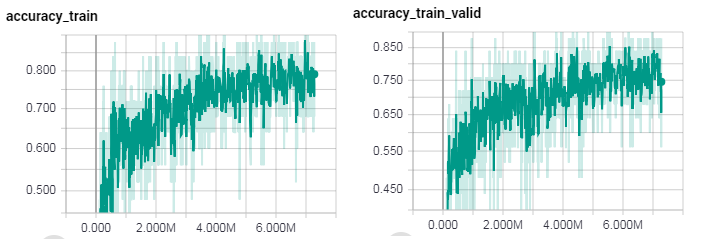

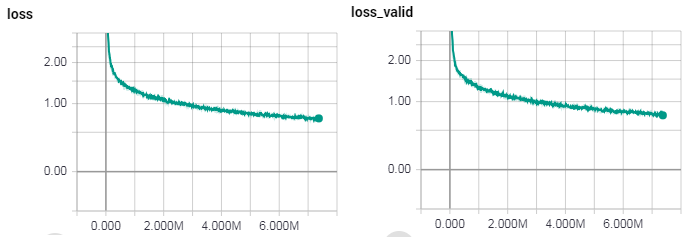

Looking at our accuracy and loss we can see that overall this model trained should perform very well. The loss after 5 hours of training was in the low 70's with the accuracy remaining in the high 80's. We noticed when examining the output of our model that it began to overfit the data halfway-in. This caused the machine to produce garbled output at the end of its run making it a good model but not the best. With more information and possibly a longer run this model would perform the best. To prevent overfitting we would choose a larger text set with more variety. Along with this we would implement early stopping. The measure of when to stop would be when the model starts producing less "english" words. This could be done by storing a ratio of how "english" the sentence being produced is. As this ratio begins to decrease we would stop the model. 

Below is our the best example of our model stopped at 30,000 epochs before overfitting begins.

In [27]:
#TESTING NOW
selector = model_selector()
parameters = {
                #TRAINING ARGS
                'vocab_size': vocab_size,
                'n_steps': 25,
                'n_batches': 100,
                'n_epochs': 30000,
    
                #GRAPH ARGS
                #MUST CHANGE LAYER_TYPE MANUALLY
                'layer_type':'GRU',
                'n_layers': 10,
                'n_neurons': 100,
                'learning_rate': 0.00105,
    
                #ANALYSIS ARGS
                'verbose': 5000,
                'len_sentence':100      
            }

selector.initialize(parameters, 2, 15)

---------------------------------------------------------------------------
MODEL INITIALIZING
Batch Shape X: (100, 25, 69)
Batch Shape y: (100, 25)
Graph Shape
X: (?, ?, 69)
y: (?, ?)
outputs: (?, ?, 100)
states: (100,)
logits: (?, ?, 69)
prediction (?, ?, 69)
output: (?, ?)
MODEL INITIALIZED
---------------------------------------------------------------------------
epoch 0
current time: 05:52:12.886752
accuracy 0.2
loss 4.231407
y_batch examination:
expected output: ' when his eye chanced to
  actual output:                          

OUTPUT: hx
,SqAxr)ZnCl.yFIPo]_UOxJvSdM['GSjF_Pv[Xv'X!o?aCg_)kd?n.'lY[ZtIG]NyD?Sk-GJWJ!KPaPcl..X,l-(U
zy.-!zX? 

---------------------------------------------------------------------------
epoch 5000
current time: 06:08:29.541156
accuracy 0.4
loss 1.5096368
y_batch examination:
expected output:  eat bats?' and sometimes
  actual output:  tvt ouce ' snd th e hded

OUTPUT: w?' taid
the Hatter a dotn.

'Ot cayling with all over damled 'AyTs-spot, 'that as 

Following is 20 samples of our model after 30,000 epochs of training. Given more training, better optimization, and more data the model could perform much better.

In [39]:
for _ in range(0,20):
    selector.sample_last_model(100,'','')

INFO:tensorflow:Restoring parameters from my_model_final_machine_final_2.ckpt
OUTPUT: xet as she was as buck and sension down, and not a
little swritp,
and carloming of a
mawar,
  Mlt Mas 

---------------------------------------------------------------------------
INFO:tensorflow:Restoring parameters from my_model_final_machine_final_2.ckpt
OUTPUT:  taalce, and (op!' said at the meating, and beginst: 'A snildarfalfer at last as I
tullr, and back a  

---------------------------------------------------------------------------
INFO:tensorflow:Restoring parameters from my_model_final_machine_final_2.ckpt
OUTPUT: qey
Ileud,
thit cay--(Birsinc-Huca, 'as won's cents hot she walk arh how hourhs all hedgebfing herh s 

---------------------------------------------------------------------------
INFO:tensorflow:Restoring parameters from my_model_final_machine_final_2.ckpt
OUTPUT: ?'

'Hh what I suppose?' said Alice cruce ucoached sarlied uopeched and again.' Fertave Rolvers was s 

------------

# Conclusion
We were able to get some pretty convincing output for this, considering it's randomly generated by a computer. Unfortunately we were not able to take the time to train this model on the huge tome that is "Infinite Jest", but nonetheless, we not only replicated Karpathy's RNN, but improved upon it in terms of performance in our second model.   

There are seemingly endless variations, shapes, and flavors of solutions to this problem set in the realm of neural networks, it is both daunting and rewarding to begin scratching the surface of these possibilities. It was also quite a wake-up call in trying to run a grid-search like exploration of best parameters in the construction of our net, as the combinations of parameters quickly ballooned out of practical proportion. The limitation of computing resources and time was quite apparent. It would be interesting to explore how much of the net could be re-used in replicating another text, presumably some lower layers would simply be tracking basic linguistics like words that are actually in the dictionary, and basic sentence structure and grammar. Frequency of words and the "style" of writing might be things that you'd only need a couple of higher layers of cells to accomplish. 